# 0. Постановка задачи

Имеется датасет, содержащий демографическую информацию и учебную статистику учащихся в возрасте от 15 до 22 лет. На его основе предполагется разработать модель, предсказываюущю результаты госэкзамена по математике на основе представленных в датасете факторов. 
Требуется провести анализ и обработку данных с целью устранения технического брака (пропуски, некорректные значения и.т.п.), выбросов и избыточных параметров (колинеарные другим параметрам, не влияющим на целевой параметр); коррекции типов данных; и в целом оптимизации датасета для дальнейшей работы с ним.

# 1. Загрузка данных и первичный анализ.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
from random import random
import re
import math

pd.set_option('display.max_columns', 50)
df = pd.read_csv('stud_math.csv')
display(df.head(10))
df.info()



,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
school                 395 non-null object
sex                    395 non-null object
age                    395 non-null int64
address                378 non-null object
famsize                368 non-null object
Pstatus                350 non-null object
Medu                   392 non-null float64
Fedu                   371 non-null float64
Mjob                   376 non-null object
Fjob                   359 non-null object
reason                 378 non-null object
guardian               364 non-null object
traveltime             367 non-null float64
studytime              388 non-null float64
failures               373 non-null float64
schoolsup              386 non-null object
famsup                 356 non-null object
paid                   355 non-null object
activities             381 non-null object
nursery                379 non-null object
studytime, granular    388 non-

Даже навскидку видно, что а) почти все колонки содержат пропуски и б) при том, что все численные данные (количественные, ранговые и номинативные) изначально целые, представлены они другими типами. И с этим придется предметно разбираться. Но сначала приведем названия колонок к единому рациональному формату.


In [2]:
# пробел с запятой это совсем некомильфо
df.rename(columns={'studytime, granular': 'studytime_gran'}, inplace=True)

#заглавные буквы заменяем на строчные с прочерком
df.columns=['_'.join(re.sub( r'([A-Z])', r'\1 ', x).split()).lower() for x in df.columns]

#названия из двух слов разбиваем на два через прочерк
df.columns=['_'.join(re.sub( r'(up|time|size|rel|out)', r' \1', x).split()).lower() for x in df.columns]
df.head()

,school,sex,age,address,fam_size,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,travel_time,study_time,failures,schools_up,fams_up,paid,activities,nursery,study_time_gran,higher,internet,romantic,fam_rel,free_time,go_out,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


Поскольку ситуацию с пропусками будем проверять по ходу дела не раз, создадим отдельную функцию для вывода статистики по пропускам. На всякий случай предусмотрим возможность подсчета в подмножестве датасета и краткого вывода.

In [3]:
def count_missing(data=df, full=True):
    
    ''' Подсчет пропусков в данных '''
    
    
    total_rows = data.shape[0]
    total = data.shape[0] * data.shape[1]
    total_missed = data.isnull().sum().sum()
    print('Пропуски в {} колонках:'.format(data.isnull().any().sum()))  
    max_len = max([len(x) for x in data.columns])
    fmt_line='{{:<{}}}: {{}} ({{:.2%}})'.format(max_len+1)
    if full:
        for column in data.columns:
            missed = data[column].isnull().sum()

            if missed: 
                print(fmt_line.format(column, missed, missed/total_rows))
    rows_ = total_rows - len(data.dropna())        
    print('всего пропусков: {} ({:.2%})'.format(total_missed, total_missed/total))
    print('всего строк с пропусками: {}: ({:.2%})'.format( rows_, rows_/total_rows))
    
    return None    
     
count_missing()

Пропуски в 27 колонках:
address         : 17 (4.30%)
fam_size        : 27 (6.84%)
p_status        : 45 (11.39%)
m_edu           : 3 (0.76%)
f_edu           : 24 (6.08%)
m_job           : 19 (4.81%)
f_job           : 36 (9.11%)
reason          : 17 (4.30%)
guardian        : 31 (7.85%)
travel_time     : 28 (7.09%)
study_time      : 7 (1.77%)
failures        : 22 (5.57%)
schools_up      : 9 (2.28%)
fams_up         : 39 (9.87%)
paid            : 40 (10.13%)
activities      : 14 (3.54%)
nursery         : 16 (4.05%)
study_time_gran : 7 (1.77%)
higher          : 20 (5.06%)
internet        : 34 (8.61%)
romantic        : 31 (7.85%)
fam_rel         : 27 (6.84%)
free_time       : 11 (2.78%)
go_out          : 8 (2.03%)
health          : 15 (3.80%)
absences        : 12 (3.04%)
score           : 6 (1.52%)
всего пропусков: 565 (4.77%)
всего строк с пропусками: 298: (75.44%)


С одной стороны пропусков у нас в пределах 5% от всех данных, т.е. уровень потерь в статистически приемлемых пределах. С другой стороны, пропусками поражено 75% всех строк, т.е. проблема намного масштабнее, чем выглядит на первый взгляд. Как минимум, невозможно привести целочисленные данные к соответствующему типу.
Поскольку никаких источников о предыстории датасета у нас нет, полагаться придется только на доступный здравый смысл и анализ даннных. Поскольку задача становится комплексной, изложение во втором разделе не столько отображает фактическую последовательность действий, сколько структурирует итоги.

Руководящий принцип в данном случае: пропуски и прочий брак в первую очередь устраняются для того, чтобы избежать некорректной обработки данных (в т.ч. программных сбоев по ошибке данных). Поскольку обратиться к первоисточникам и надежно восстановить утраченные данные мы никак не можем, основной приоритет - внести в процессе как можно меньше искажений.



# 2. Обработка данных

## 2.1 Корректность значений и выбросы

Для существенной части параметров нам изначально заданы допустимые значения.

In [4]:
allowed_values = {'sex': ('F','M'),
                  'age': range(15,23),
                  'address': ('U', 'R'),
                  'fam_size': ('LE3', 'GT3'),
                  'p_status':('T', 'A'),
                  'm_edu': range(5),   
                  'f_edu': range(5),  
                  'm_job': ('teacher', 'health', 'services', 'at_home', 'other'),
                  'f_job': ('teacher', 'health', 'services', 'at_home', 'other'),
                  'reason': ('home', 'reputation', 'course', 'other'),
                  'guardian': ('mother', 'father', 'other'),
                  'travel_time': range(1,5),
                  'study_time': range(1,5),
                  'failures': (1,2,4),
                  'schools_up': ('yes', 'no'),
                  'fams_up': ('yes', 'no'), 
                  'paid': ('yes', 'no'), 
                  'activities': ('yes', 'no'), 
                  'nursery': ('yes', 'no'), 
                  'higher': ('yes', 'no'), 
                  'internet': ('yes', 'no'), 
                  'romantic': ('yes', 'no'), 
                  'fam_rel': range(1,6), 
                  'free_time': range(1,6),
                  'go_out': range(1,6), 
                  'health': range(1,6), 
                                   }

Проверим насколько (формально) корректны имеющиеся данные по этим столбцам.

In [5]:
for column in allowed_values:
    out_of_range = df[~df[column].isin(allowed_values[column])][column].dropna()
    if len(out_of_range): 
        display(out_of_range.value_counts())

40.0    1
Name: f_edu, dtype: int64

0.0    293
3.0     15
Name: failures, dtype: int64

-1.0    1
Name: fam_rel, dtype: int64

Отрицательное значение в ***fam_rel*** можно объяснить тем, что в анкете перед цифрой было тире ("отношения - 1"), что при переносе в компьютер превратилось в "-1". 

In [6]:
df.fam_rel.replace(-1, 1, inplace=True)

Число "40" в ***f_edu*** могло появиться при введении "4" на нумпэде. Большой палец в этом случае находится как раз над нулем и при известной неаккуратности движений можно ввести и его.

In [7]:
df.f_edu.replace(40.0, 4, inplace=True)

Большое удивление вызывает то, что практически весь столбец ***failures*** (какая ирония!) содержит недопустимые значения. В исходном описании параметра они описаны, как "*количество внеучебных неудач (n, если 1<=n<3, иначе 4)*". Здесь можно предположить некорректность описания. Например, почему ноль неудач в принципе исключен как опция? Наверно подразумевалось, что речь идет о количестве имеющихся неудач. Ну и судя по полному отсутствию значения 4, и наличии значения 3, все-таки имелось ввиду, что меньше или равно трем. То есть принцип параметра: ноль, если нет неудач; количество неудач, если оно не больше трех; 4 для всех остальных количеств неудач (чтобы "подтянуть хвост" небольшого количества разрозненных значений в более компактный параметр). Ну а при анкетировании уже оказалось, что заложенное в принцип предположение о вакууме за тройкой подтвердилось полностью. 

То есть, имеем всего две альтернативы действий. Первая -  некорректно описание в ТЗ, а параметр корректен целиком. Либо с точностью до наоборот, и столбец является полным браком, никак не устранимым (целиком под удаление). Оставляем столбец как есть - просто потому, что удалить-то данные просто, вернуть сложнее - сопроводив соответствующим комментарием.

Не забудем, что нам еще прогонять попарные тесты Стюдента, и не хотелось бы заряжать в них совсем карликовые выборки. А в случае ранговых переменных значение может формально не быть выбросом, но представлено микроскопически. Включаем микроскоп.

In [8]:
for column in allowed_values:
    vc = df[column].value_counts(normalize=True, dropna=True)
    if vc.iloc[-1] < 0.02:
        print(column, vc[vc < 0.02])

age 20    0.007595
22    0.002532
21    0.002532
Name: age, dtype: float64
m_edu 0.0    0.007653
Name: m_edu, dtype: float64
f_edu 0.0    0.005391
Name: f_edu, dtype: float64
travel_time 4.0    0.019074
Name: travel_time, dtype: float64


Первым пунктом у нас идет параметр ***age***, который в данном контексте можно трактовать и как ранговый и как количественный. В любом случае, по сравнению с "официально" ранговыми более вариативен. Возраст сам по себе реалистичен, проверим адресно на выбросы. 

16    104
17     98
18     82
15     82
19     24
20      3
22      1
21      1
Name: age, dtype: int64

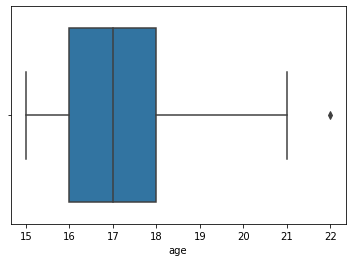

In [9]:
sns.boxplot(df.age)
df.age.value_counts()

Засидеться в школьниках до 22 лет - это явный выброс, не только по статистическим параметрам, но и по здравому смыслу. Но и то, что внутри "усов" смотрится не очень убедительно. Имеет смысл воспользоваться описанным выше (но фактически не примененным авторами данных) принципом и скомпрессировать все, что от 20 лет в одно значение: 20.

In [10]:
df.age.replace(21,20, inplace = True)
df.age.replace(22,20, inplace = True)

К остальным трем параметрам из списка мы вернемся чуть позже, а пока обратим внимание на численные данные без заданных явно ограничений - это пропуски занятий, и собственно основной параметр - экзаменационный балл учащегося.

count    383.000000
mean       7.279373
std       23.465197
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

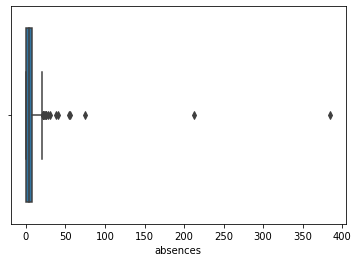

In [11]:
display(df.absences.describe())
sns.boxplot(df.absences)

 При 365(6) днях в году, как минимум одно из значений параметра уже удивительно. Если взять за референс отечественную школьную программу старших классов, то речь идет о 200 часах в год. И второе по величине значение тоже выглядит сомнительным. 
К сожалению, в ТЗ не уточняется в явном виде, за какой период считаются пропуски занятий (выпускной год или это вся история учащегося). Также в явном виде не указано о чем идет речь - о всех занятиях вообще (один день может мультиплицироваться в соответствующее количество занятий) или только о математике. Микс из максимально локального и максимально обобщенного подходов может дать похожий результат. Посмотрим на точные границы "усов". (Для чего напишем функцию. Не пригодится еще раз в этой работе - пригодится потом).

In [12]:
def limits (data):

    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3-q1
   
    return  q1-1.5*iqr, q3+1.5*iqr
limits(df.absences)

(-12.0, 20.0)

Верхняя граница по формуле у нас получилась 20, но формула - не истина в последней инстанции, есть еще здравый смысл. Посмотрим, что будет если провести границу на значении 30.

,absences,score
74,54.0,55.0
183,56.0,40.0
222,385.0,85.0
276,75.0,45.0
307,38.0,40.0
315,40.0,55.0
390,212.0,45.0


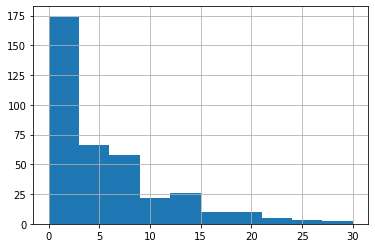

In [13]:
display(df[df['absences'] > 30][['absences','score']])
df[df['absences']<= 30].absences.hist()

На отрезке 20-30 количество прогулов продолжает сходить на нет плавно, так что это не выброс, а часть распределения. Также, не сказать, что "хвост" прогулов ведет нас в "хвост" оценок. Имеет смысл по уже использованному подходу скомпрессировать всё выше 30 в одно значение - 30. Что касается экстремальных значений, с т.з. статистических искажений, их коррекция вряд ли окажется хуже удаления строк целиком. 


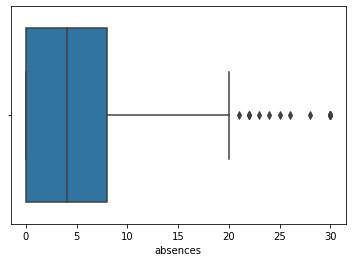

In [14]:
gt_30 = df[df.absences >30].index
df.loc[gt_30,'absences'] = 30
sns.boxplot(df.absences)

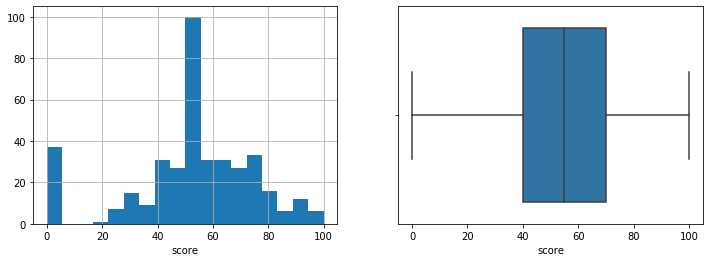

In [15]:
def hist_and_box (df_column):
    
    """ Для удобства вывод гистограммы и боксплота по одному параметру в ряд
    
        На входе колонка (не название, а сам объект pd.Series)"""
    
    bins= len(df_column.value_counts())
    fig = plt.figure(figsize=(12, 4)) 
    ax_1 = fig.add_subplot(121)
    ax_1.set_xlabel(df_column.name)
    df_column.hist(bins=bins, ax=ax_1)
    sns.boxplot(df_column, ax=fig.add_subplot(122))
    plt.show()
    return None

hist_and_box(df.score)

Обращают на себя внимание два выраженных пика. Очевидно, что применение теста Стюдента при таком отклонении от нормального характера распределения целевого признака будет сопряжено с погрешностями. Устранить основной пик в любом случае не представляетя возможным. Главный пик в оценках условного ЕГЭ может объясняться структурой самого экзаменационного теста. Например, в нем есть "легкая" половина, с которой справляется подавляющее большинство учащихся, и которая позволяет максимум выпускников на проходной балл, а задачи сложнее реально требуют знаний. 

Что касается пика в нуле, самые рациональные гипотезы:
* Это скрытый пропуск, автоматически заполненный нулями на каком-то этапе подготовки датасета.
* Это реальное количество не решивших ни одной задачи. (В конце концов, в исследовании у нас всего две школы, и еще неизвестно, насколько (не)благополучными они считаются.
* Это не допущенные к экзамену ученики, не сдавшие необходимые зачеты. (Могли бы все равно не получить проходной балл, но не полный ноль)
* Ученики, не допущенные к экзаменам или не пришедшие сдавать экзамен по причинам, не связанным с успеваемостью по математике. Вопрос возникает ровно с тем, считать ли эти причины устранимыми, или принять за данность, что 10% учащихся покидает школу по причинам, находящимся за рамками собственно педагогики.

Ответов на эти вопросы нет, и нельзя сказать, что версии за удаление нулей выглядят более убедительными.


## 2.2 Устранение пропусков и коррекция типов данных

И с все той же колонки score начнем работу с пропусками. Поскольку этот признак собственно является предметом исследования, заполнение пропусков в нем никак не может улучшить качество исследования. И эти строки придется удалить, как неинформативные.

In [16]:
df.dropna(subset=['score'], inplace=True)
df.score = df.score.astype('int')

Пропуски в количественных параметрах - ***absences, age, failures*** - заполним медианными значениями.

In [17]:
for column in ( 'absences', 'age', 'failures'):
    df[column] = df[column].fillna(df[column].median()).astype('int')
    
count_missing()

Пропуски в 24 колонках:
address         : 15 (3.86%)
fam_size        : 27 (6.94%)
p_status        : 45 (11.57%)
m_edu           : 3 (0.77%)
f_edu           : 24 (6.17%)
m_job           : 19 (4.88%)
f_job           : 36 (9.25%)
reason          : 17 (4.37%)
guardian        : 31 (7.97%)
travel_time     : 28 (7.20%)
study_time      : 7 (1.80%)
schools_up      : 9 (2.31%)
fams_up         : 38 (9.77%)
paid            : 39 (10.03%)
activities      : 14 (3.60%)
nursery         : 15 (3.86%)
study_time_gran : 7 (1.80%)
higher          : 20 (5.14%)
internet        : 34 (8.74%)
romantic        : 31 (7.97%)
fam_rel         : 27 (6.94%)
free_time       : 9 (2.31%)
go_out          : 7 (1.80%)
health          : 15 (3.86%)
всего пропусков: 517 (4.43%)
всего строк с пропусками: 288: (74.04%)


Оставшиеся параметры у нас относятся к номинативным или ранговым. С т.з. заполнения к ранговым теоретически применимо (когда это оправдано) заполнение медианой, в остальном набор доступных методик будет совпадать:
*  заполнение наиболее частым значением
*  заполнение случайным/экстраполированным значением согласно распределению в колонке
*  заполнение по взаимосвязи с другим параметром


In [18]:
def fill_by_frequency (column, missing=[], source=[]):


    """Заполнение пропусков в номинативных и/или дискретных данных на основе частотного распределения
    
    Аргументы:
    column  -- колонка, в которой заполняются пропуски
    missing -- индекс заполнения (по умолчанию пустой)
    source  -- выборка значений, по которой считается частота (по умолчанию пустая)
    
    """
    
    # если на входе пустая выборка, заполняем все пропуски на основе распределения в колонке
    if len(source) == 0:
        source = df[column]
    # если на входе пустой индекс, заполняем все строки в колонке  
    if len(missing) == 0:
        missing = df[df[column].isnull()].index
  
    # строим таблицу функции распределения    
    freq = source.value_counts(normalize=True, ascending=True, dropna=True).cumsum()
    
    # подставляем соответствующее случайной величине от 0 до 1 значение из таблицы
    fill_na = df.loc[missing][column].apply(lambda x: freq[freq >= random()].idxmin())

    return fill_na




def fill_by_related (target, source, method='mode'):
    
    """Заполнение пропусков по связи с другим параметром
    
    Аргументы: 
    target -- целевой параметр
    source -- параметр на основе которого группируем выборки целевого параметра
    method -- применяемый метод заполнения (по умолчанию - мода):
                - mode: мода
                - median: медиана (только для численных параметров)
                - freq: набор значений, сгенерированный на основе исходного распределения
                
    
    """
    
    # цикл по значениям параметра, по которому группируем значения в колонке
    for source_value in df[source].dropna().unique():
        
        
        to_fill = df.loc[(df[source] == source_value) & df[target].isnull()].index
        sample = df[df[source] == source_value][target].dropna()
           
        if method == 'mode':
            df.loc[to_fill, target] = sample.mode()[0]
            
        elif method == 'median':
            try: # контроль на случай, если не числовой параметр
                df.loc[to_fill, target] = sample.median()
            except Exception as e:
                print('сбой при попытке посчитать медиану', e)
                
        elif method == 'freq':
             df.loc[to_fill, target] = fill_by_frequency(target, to_fill,  sample)
                
        else:
            raise ValueError('некорректно задан метод', method)
            
        
    return None   


Кроме того, есть отдельный случай - "скрытый ноль", когда на первичном этапе сбора информации поле в форме (электронной или бумажной) остается пустым, потому что тот, кто заполнял не утруждал себя заполнением "нулевого" ответа (как правило - собственно ноль, "нет", возможно "иное" и т.п.).

У нас имеется довольно большая группа бинарных признаков "да/нет", в которых пропуски могут быть как раз скрытыми нулями и означать "нет" 

In [19]:
yay_or_nay = [x for x in df.columns if set(df[x].dropna().unique()) == {'yes','no'}]
count_missing(df[yay_or_nay])
df[yay_or_nay].describe()


Пропуски в 8 колонках:
schools_up : 9 (2.31%)
fams_up    : 38 (9.77%)
paid       : 39 (10.03%)
activities : 14 (3.60%)
nursery    : 15 (3.86%)
higher     : 20 (5.14%)
internet   : 34 (8.74%)
romantic   : 31 (7.97%)
всего пропусков: 200 (6.43%)
всего строк с пропусками: 172: (44.22%)


,schools_up,fams_up,paid,activities,nursery,higher,internet,romantic
count,380,351,350,375,374,369,355,358
unique,2,2,2,2,2,2,2,2
top,no,yes,no,yes,yes,yes,yes,no
freq,331,216,197,192,297,350,300,235


Поскольку мы работаем в поле совершенно открытом с т.з. гипотез о предыстории данных, эта гипотеза видится вполне приемлемой. Ну и одновременно сконвертируем "да/нет" в бинарный код. 


In [20]:
df[yay_or_nay] = df[yay_or_nay].fillna('no')
for column in yay_or_nay:
    df[column] = df[column].str.contains('yes').astype('int')

In [21]:
count_missing()

Пропуски в 16 колонках:
address         : 15 (3.86%)
fam_size        : 27 (6.94%)
p_status        : 45 (11.57%)
m_edu           : 3 (0.77%)
f_edu           : 24 (6.17%)
m_job           : 19 (4.88%)
f_job           : 36 (9.25%)
reason          : 17 (4.37%)
guardian        : 31 (7.97%)
travel_time     : 28 (7.20%)
study_time      : 7 (1.80%)
study_time_gran : 7 (1.80%)
fam_rel         : 27 (6.94%)
free_time       : 9 (2.31%)
go_out          : 7 (1.80%)
health          : 15 (3.86%)
всего пропусков: 317 (2.72%)
всего строк с пропусками: 214: (55.01%)


Сокращение списка сделало соседями параметры study_time и study_time_gran(ular), и сходство их названий дополнилось сходством по количеству пропусков...

In [22]:
df.study_time.corr(df.study_time_gran)
(df.study_time/df.study_time_gran).value_counts()

-0.333333    382
dtype: int64

...как видим, не случайно. Очевдино, что study_time_gran - это масштабированный по каким-то соображениям параметр study_time. 
В ТЗ этот параметр не указан, и является относительно исходного избыточным. Исходник надо безусловно оставлять, потому что он трактуется однознозначно. Предположим, что масштабированный параметр реально нужен. Тогда мы сначала корректируем исходную колонку, потом по тому же принципу заполняем масштабированную. Лучше всего заполнить масштабированную путем вычисления от исходной - если вдруг изменим решение относительно метода заполнения, меньше придется переделывать в коде.


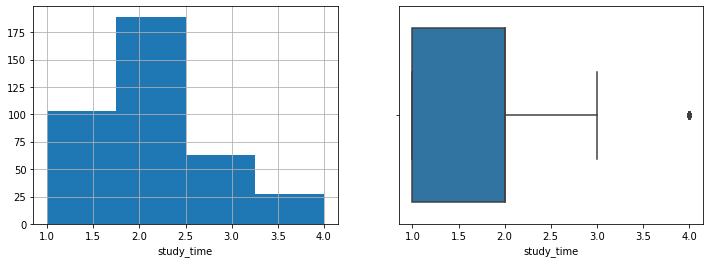

count    382.000000
mean       2.036649
std        0.847239
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: study_time, dtype: float64

In [23]:
hist_and_box(df.study_time)
df.study_time.describe()

Здесь в качесте заполнения напрашивается медиана, которая к тому же и с большим отрывом лидирует по частоте встречаемости.

In [24]:
df.study_time = df.study_time.fillna(df.study_time.median()).astype('int')
df.study_time_gran = df.study_time_gran.fillna(-3 * df.study_time).astype('int')
count_missing()

Пропуски в 14 колонках:
address         : 15 (3.86%)
fam_size        : 27 (6.94%)
p_status        : 45 (11.57%)
m_edu           : 3 (0.77%)
f_edu           : 24 (6.17%)
m_job           : 19 (4.88%)
f_job           : 36 (9.25%)
reason          : 17 (4.37%)
guardian        : 31 (7.97%)
travel_time     : 28 (7.20%)
fam_rel         : 27 (6.94%)
free_time       : 9 (2.31%)
go_out          : 7 (1.80%)
health          : 15 (3.86%)
всего пропусков: 303 (2.60%)
всего строк с пропусками: 213: (54.76%)


Можно предположить, что есть определенная связь между местом проживания учащихся и школой.

In [25]:
display(df.groupby(['school'])['address'].value_counts())

school  address
GP      U          273
        R           60
MS      R           23
        U           18
Name: address, dtype: int64

Похоже, что так и есть. Заполним в соответствии с частотой распределения параметра в зависимости от школы.

In [26]:
fill_by_related('address', 'school', method='freq')

Также можно предположить, что travel_time зависит о места проживания.

In [27]:
display(df.groupby(['address'])['travel_time'].value_counts(normalize=True))

address  travel_time
R        1.0            0.443038
         2.0            0.354430
         3.0            0.151899
         4.0            0.050633
U        1.0            0.723404
         2.0            0.234043
         3.0            0.031915
         4.0            0.010638
Name: travel_time, dtype: float64

В городе явно в целом тратят меньше времени. Заполним медианным значением в зависимости от места проживания. Также надо ометить, что значение 4 встречается в очень маленьком проценте и на тестах может привести к искажениям. Поскольку в строках могут быть и полезные данные, переформулируем ранг 3, как "от получаса и выше" и уберем все четверки в него.

In [28]:
fill_by_related('travel_time', 'address', method='freq')
df.travel_time = df.travel_time.astype('int').replace(4,3)
df.travel_time.value_counts()

1    255
2    104
3     30
Name: travel_time, dtype: int64

Поскольку семейные пары, как правило, образуются в рамках социокультурной общности, логично предположить, что уровни образования у отцов и матерей примерно совпадают.

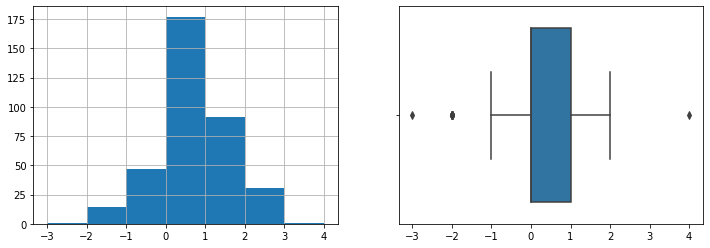

0.6219813871588825

In [29]:
hist_and_box(df.m_edu - df.f_edu)
df.m_edu.corr(df.f_edu)

Вполне возможно заполнить пропуски  модой в зависимости от образования супруга.

In [30]:
fill_by_related('m_edu', 'f_edu', method='mode')
fill_by_related('f_edu', 'm_edu', method='mode')
df.f_edu = df.f_edu.astype('int')
df.m_edu = df.m_edu.astype('int')
count_missing()

Пропуски в 10 колонках:
fam_size        : 27 (6.94%)
p_status        : 45 (11.57%)
m_job           : 19 (4.88%)
f_job           : 36 (9.25%)
reason          : 17 (4.37%)
guardian        : 31 (7.97%)
fam_rel         : 27 (6.94%)
free_time       : 9 (2.31%)
go_out          : 7 (1.80%)
health          : 15 (3.86%)
всего пропусков: 233 (2.00%)
всего строк с пропусками: 184: (47.30%)


Оставшиеся ранговые переменные заполним просто медианой.

In [31]:
for column in ('fam_rel', 'free_time', 'go_out', 'health'):
    df[column] = df[column].fillna(df[column].median()).astype('int')
count_missing()

Пропуски в 6 колонках:
fam_size        : 27 (6.94%)
p_status        : 45 (11.57%)
m_job           : 19 (4.88%)
f_job           : 36 (9.25%)
reason          : 17 (4.37%)
guardian        : 31 (7.97%)
всего пропусков: 175 (1.50%)
всего строк с пропусками: 150: (38.56%)


Имеется два бинарных признака, у которых нет значений, которые могли бы привести к возникновению скрытых нулей.

In [32]:
display(df.fam_size.value_counts())
display(df.p_status.value_counts())

GT3    255
LE3    107
Name: fam_size, dtype: int64

T    308
A     36
Name: p_status, dtype: int64

Их можно заполнить по частоте распределения.

In [33]:
for column in ('fam_size', 'p_status'):
    df[column].fillna(fill_by_frequency(column), inplace=True)

count_missing()

Пропуски в 4 колонках:
m_job           : 19 (4.88%)
f_job           : 36 (9.25%)
reason          : 17 (4.37%)
guardian        : 31 (7.97%)
всего пропусков: 103 (0.88%)
всего строк с пропусками: 97: (24.94%)


У оставшихся номинативных переменных есть теоретическая возможность того, что значение 'other' является скрытым нулем. Оно и само по себе неплохой заполнитель пустот, можно сказать, просится в пропуски. Для очистки совести, посмотрим, не выбивается ли оно из уровней образования родителей.

In [34]:
display(df[df.f_job == 'other'].f_edu.value_counts())
display(df[df.m_job == 'other'].m_edu.value_counts())

display(df[df.m_edu == 0].m_job.value_counts())
display(df[df.f_edu == 0].f_job.value_counts())

2    59
3    53
1    46
4    34
0     2
Name: f_edu, dtype: int64

2    44
3    36
1    24
4    22
0     1
Name: m_edu, dtype: int64

at_home    2
other      1
Name: m_job, dtype: int64

other    2
Name: f_job, dtype: int64

Совесть достаточно чиста, поэтому все оставшееся будет у нас "прочим". Но, в процессе мы обнаружили, что родители без образования у нас присутствуют в штучном количестве. Т.е. по факту это выброс, который сам по себе не репрезентабелен, и чреват внесением искажений в расчеты. Следуя принципу "по возможности не удалять", переформулируеум ранг 1, как "начальное или никакого" и уберем в него нули.

In [35]:
df.f_edu.replace(0, 1, inplace=True)
df.m_edu.replace(0, 1, inplace=True)

In [36]:
df.fillna('other', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 30 columns):
school             389 non-null object
sex                389 non-null object
age                389 non-null int32
address            389 non-null object
fam_size           389 non-null object
p_status           389 non-null object
m_edu              389 non-null int32
f_edu              389 non-null int32
m_job              389 non-null object
f_job              389 non-null object
reason             389 non-null object
guardian           389 non-null object
travel_time        389 non-null int32
study_time         389 non-null int32
failures           389 non-null int32
schools_up         389 non-null int32
fams_up            389 non-null int32
paid               389 non-null int32
activities         389 non-null int32
nursery            389 non-null int32
study_time_gran    389 non-null int32
higher             389 non-null int32
internet           389 non-null int32
romantic    

Итого:
* Имеем датасет из 383 строк с 30 колонками данных. 
* Все численные данные (21 признак) представлены целочисленным форматом
* Из них к количественным без оговорок можно отнести три: ***score, abscences*** и ***age***
* Восемь бинарных признаков "0/1" получены из фомата "да/нет"
* Остальные численные признаки являются ранговыми.
* Среди них обнаружено два абсолютно колинеарных признака ***study_time*** и ***study_time_gran*** (второй - масштабированный вариант первого). 
* Оставшиеся 9 признаков являются номинативными и представлены строковыми значениями.


# 3. Анализ данных

## 3.1 Корреляционный анализ.

Количественных переменных, включая цель исследования у нас всего три (попробуем назначить на эту должность и ***age***, у которой количество значений хотя бы больше пяти), поэтому матрицу рассеяния можно не ужимать.

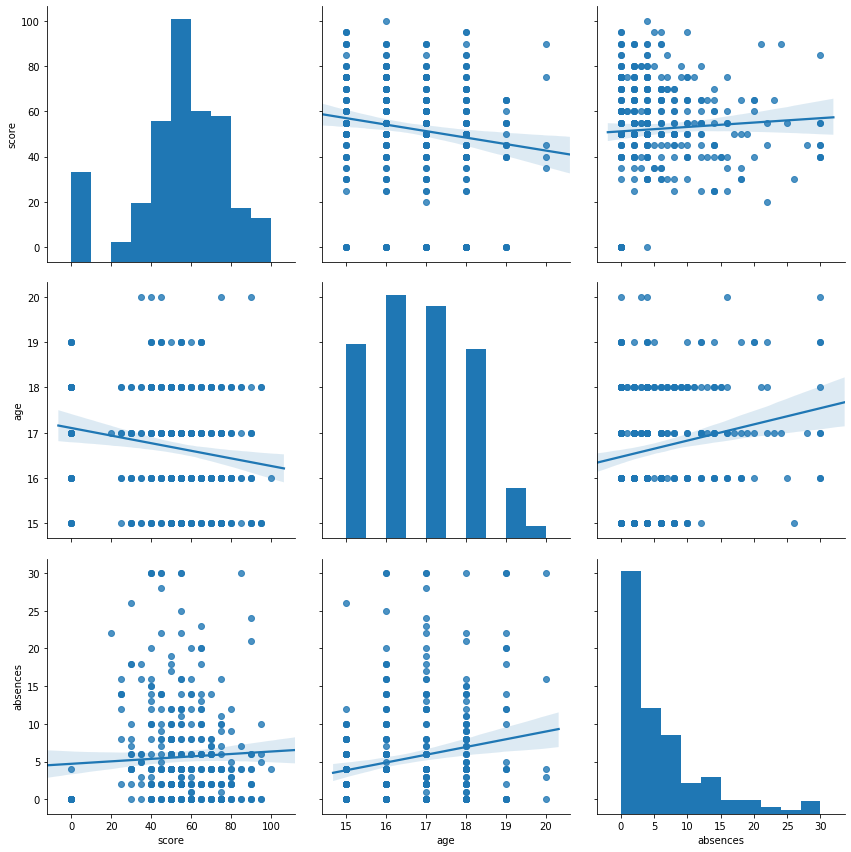

-0.15516384402634562
0.05628379057435256


In [37]:
num_values=['score','age', 'absences']
sns.style=('ticks')

sns.pairplot(df[num_values] ,kind = 'reg', height=4)
plt.show()
print(df.score.corr(df.age))
print(df.score.corr(df.absences))

Прогулы коррелируют с итоговым баллом очень слабо (впрочем, при работе с выбросами уже были на это намеки).
Чуть более выраженной, но все равно несущественной, является корреляция оценок с возрастом. Т.е. можно говорить, что чем дольше засисделся ученик в школьниках, тем больше шанс, что успеваемость у него будет хуже средней (а попросту, учиться надоедает). Но и только.

## 3.2 Анализ номинативных  и ранговых переменных.

Поскольку у нас остается без малого три десятка переменных, автоматизируем их анализ и визуализацию таким образом, чтобы отчет был компактным.

In [38]:
def evaluate_dif(column, alpha=0.05):
    
    """ Проверка гипотезы о влиянии номинативной/ранговой переменной на исследуемый параметр
    
    column -- название колонки
    alpha  -- уровень значимости, по умолчанию 5%
    
    """
    # список значений в колонке
    values = df[column].unique()
    
    # уровень значимости с поправкой Бонферони
    alpha_bonfy = 2*alpha/(len(values)*(len(values)-1))
    
    # цикл по парам значений
    for one, two in combinations(values,2):
        
        set_one = df[df[column] == one]['score']
        set_two = df[df[column] == two]['score']
        
        if ttest_ind(set_one, set_two).pvalue <= alpha_bonfy:
            return True 
        
    return False

def multiple_boxes(columns, ncols=4, angle=0):
    
    """ Групповое построение боксплотов, визуализирующих степень зависимости исследуемого параметра
    от значений других параметров
    
    columns -- список параметров
    ncols   -- количество параметров в одном ряду графиков (по умолчанию 4)
    angle   -- угол наклона подписей по оси X (по умолчанию 0) """

    total = len(columns)
    nrows = math.ceil(total/ncols)
    fig = plt.figure(figsize = (13, 4*nrows)) 
    
    sns.set(style="whitegrid")
   
    for i, column in enumerate (columns):
        
        ax = fig.add_subplot(nrows, ncols,i+1)
        sns.boxplot(x=column, y='score', data=df, ax=ax)
        dif = evaluate_dif(column)
        ax.set_title('TTEST: '+str(dif))
        plt.xticks(rotation=angle)
        
    fig.tight_layout(pad=3)
    
    return None

По соображениям визуализации начнем с бинарных (численных и номинативных) признаков.

In [39]:
bin_vals = [x for x in df.columns if df[x].dropna().nunique() == 2]
print(len(bin_vals),bin_vals)

13 ['school', 'sex', 'address', 'fam_size', 'p_status', 'schools_up', 'fams_up', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']


Их у нас простое число, 13, что неудобно для вывода, но у нас среди них есть и без анализа первый кандидат на вылет: ***school***. Исследование у нас под эгидой ЮНИСЕФ и вряд ли эта организация хочет предсказывать успеваемость в двух конкретных школах. Эта информация была полезна при заполнении пропусков, но более мы в ней не нуждаемся.

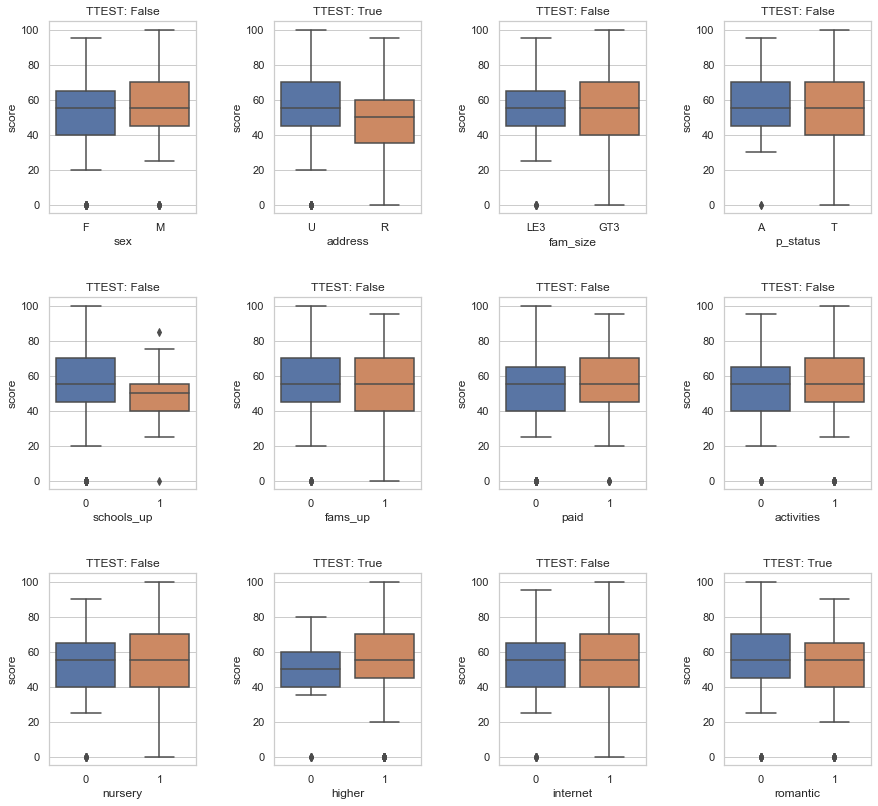

In [40]:
multiple_boxes(bin_vals[1:], ncols=4)

Первым делом самолеты, ну а девушки/юноши потом. Тест прошли переменные ***higher*** и ***romantic***. Кто больще интересуется учебой и меньше романтикой, преуспеваем в первом больше. Но, кстати, можно видеть, что между мечтами/абициями и реальной мотивацией есть различия, судя по результатам. Есть еще один параметр - ***address***, который весьма чувствителен к заполнениям и в процессе отладки кода то проходил, то не проходил тест. Условно берем его в анализ. Выбросить никогда не поздно.

In [41]:
approved = ['score','higher', 'romantic', 'address']

Далее рассмотрим все, что связано с семьей.

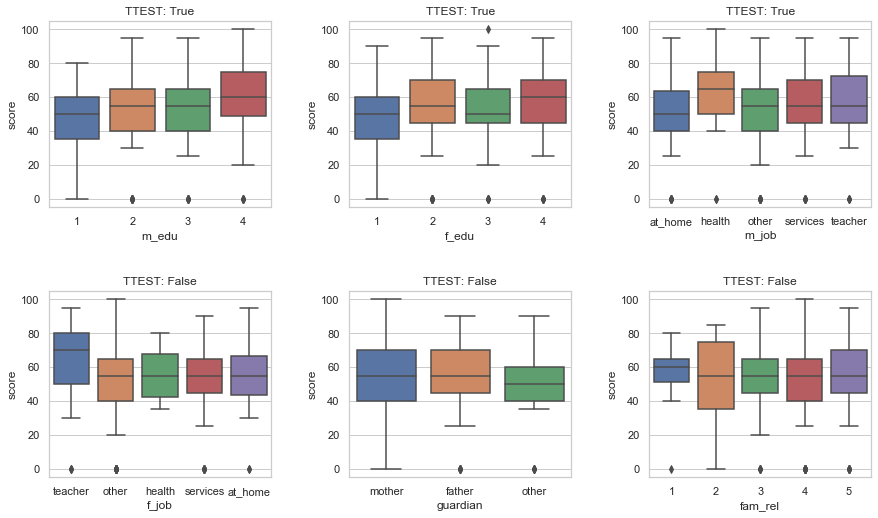

In [42]:
parental = ['m_edu', 'f_edu', 'm_job', 'f_job', 'guardian', 'fam_rel']
multiple_boxes(parental, ncols=3)

Вполне предсказуемо влияет образование родителей. Несколько удивляет влияние работы родителей. Мама-учитель не дает видимого бонуса, хотя работа мамы влияет. Видимо дело не столько в самой профессии, сколько в количестве и качестве внимания. Работа отца вроде бы не влияет, но мы помним, что поправка Бонферони - довольно-таки жесткая, гарантирующая скорее отсев лишнего, чем сохранение нужного. Учитывая, как папа-учитель, выделяется на фоне, следовало бы сохранить и ***f_job***.

In [43]:
approved += ['f_edu', 'f_job', 'm_edu', 'm_job']

Ну и окинем взглядом то, что осталось.

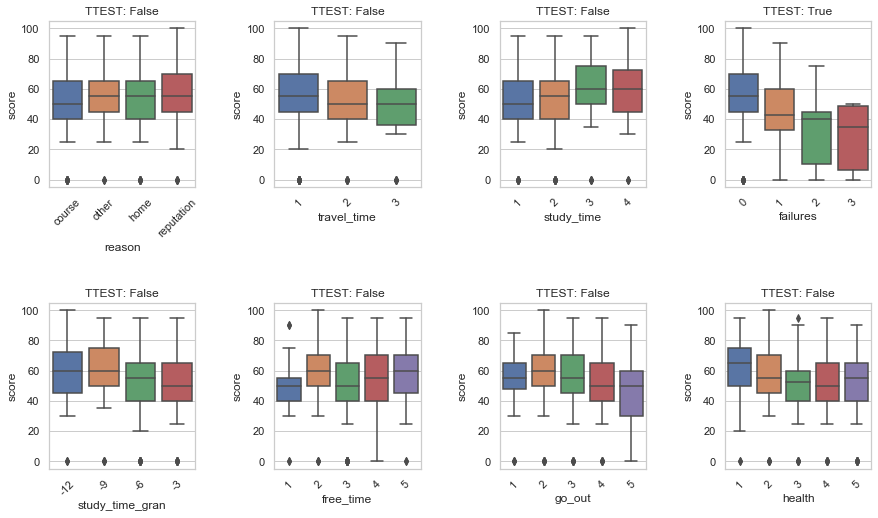

In [44]:
columns_left = df.drop(columns=bin_vals+parental+num_values).columns
multiple_boxes(columns_left, ncols=4, angle=45)

Явную зависимость демонстрирует только количество провалов. Остальные факторы слишком неоднозначны. Например, болезный может иметь мало сил на учебу, а может кроме учебы ничем не заниматься, и в ней преуспеть. Или тот, кто много занимается, может быть прилежным и результативным, а может просто иметь низкий КПД. Таким образом дилемма насчет study_time_gran разрешилась сама собой.



In [45]:
approved += ['failures']
df[approved].to_csv('new_stud_math.csv')
df[approved].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 9 columns):
score       389 non-null int32
higher      389 non-null int32
romantic    389 non-null int32
address     389 non-null object
f_edu       389 non-null int32
f_job       389 non-null object
m_edu       389 non-null int32
m_job       389 non-null object
failures    389 non-null int32
dtypes: int32(6), object(3)
memory usage: 31.3+ KB


# 4. Заключение

Рекомендуем к использованию существенно более компактный датасет, в котором кроме параметра ***score*** всего 7 переменных (из исходных 29):
*  m_edu - образование матери ( 1 - от 0 до 4 классов , 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
*  f_edu - образование отца ( 1 - от 0 до 4 классов , 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
*  m_job - работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)
*  f_job - работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)
*  higher — хочет получить высшее образование (1 - да, 0 - нет)
*  romantic — в романтических отношениях (1 - да, 0 - нет)
*  failures — количество внеучебных неудач (от 0 до 3)

Сам признак ***score*** требует дополнительного расследования касательно происхождения большого количества нулей и их трактовки.

